In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from feature_manager import FeatureManager
from dnn_classifier import DNNClassifer
from random import randint
from visualizer import *

2023-01-13 23:09:55.723495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-13 23:09:55.723625: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-13 23:09:55.723638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
old = pd.read_csv("../data/BTCUSDT-1d.csv", parse_dates=["Open Time"], index_col = "Open Time")
fm = FeatureManager()
fm.build_feature(data=old,lags=0)

In [16]:
def prepare_trade_forward_data(data, take_profit_rate = 0.05, stop_loss_rate = 0.025, max_duration = 7):
    
    fwd_cols = []

    data["long_take_profit"] = data["Close"]*(1+take_profit_rate)
    data["long_stop_loss"] = data["Close"]*(1-stop_loss_rate)

    data["short_take_profit"] = data["Close"]*(1-take_profit_rate)
    data["short_stop_loss"] = data["Close"]*(1+stop_loss_rate)


    data["cum_return_forward_0"] = data["returns"]
    data["long_decision_forward_0"] = 0
    data["short_decision_forward_0"] = 0

    str_trade_signal = "trade_signal"
    str_trade_return = "trade_profit"

    data[str_trade_return] = 0
    data[str_trade_signal] = 0
     
    for i in range(1,max_duration+1):
        
        data["High_forward_{}".format(i)] = data["High"].shift(-i)
        data["Low_forward_{}".format(i)] = data["Low"].shift(-i)
        data["cum_return_forward_{}".format(i)] = data["cum_return_forward_{}".format(i-1)]+data["returns"].shift(-i)

        long_str = "long_decision_forward_{}".format(i)
        short_str = "short_decision_forward_{}".format(i)

        fwd_cols.append(long_str)
        fwd_cols.append(short_str)

        data["long_random"] = [randint(0,100) for i in range(0,len(data))]
        data["short_random"] = [randint(0,100) for i in range(0,len(data))]
        
        #Temporarily set all open as closed
        data[long_str] = 2
        data[short_str] = 2

        ol_odd_lose_cond = data["long_random"]<50
        ol_odd_win_cond = data["long_random"]>=50

        os_odd_lose_cond = data["short_random"]<50
        os_odd_win_cond = data["short_random"]>=50

        # Compute future outcome if long position
        # 

        ol_cond = data["long_decision_forward_{}".format(i-1)]==0
        ol_tp_cond = data["High_forward_{}".format(i)] >= data["long_take_profit"]
        ol_ntp_cond = data["High_forward_{}".format(i)] < data["long_take_profit"]
        ol_sl_cond = data["Low_forward_{}".format(i)] <= data["long_stop_loss"]
        ol_nsl_cond = data["Low_forward_{}".format(i)] > data["long_stop_loss"]

        # If only stop-loss reached
        data.loc[
            ol_cond &
            ol_sl_cond &
            ol_ntp_cond,
            long_str
        ] = -1

        # If only take-profit reached
        data.loc[
            ol_cond &
            ol_tp_cond &
            ol_nsl_cond,
            long_str
        ] = 1

        data.loc[
            ol_cond &
            ol_tp_cond &
            ol_nsl_cond,
            str_trade_signal
        ] = 1

        data.loc[
            ol_cond &
            ol_tp_cond &
            ol_nsl_cond,
            str_trade_return
        ] = np.log(1 + take_profit_rate)
        
        # If both take-profit and stop-loss reached, odd say it was stoploss
        data.loc[
            ol_cond &
            ol_sl_cond &
            ol_tp_cond &
            ol_odd_lose_cond,
            long_str
        ] = -1
        
        # If both take-profit and stop-loss reached, odd say it was take-profit
        data.loc[
            ol_cond &
            ol_sl_cond &
            ol_tp_cond &
            ol_odd_win_cond,
            long_str
        ] = 1

        data.loc[
            ol_cond &
            ol_sl_cond &
            ol_tp_cond &
            ol_odd_win_cond,
            str_trade_signal
        ] = 1

        data.loc[
            ol_cond &
            ol_sl_cond &
            ol_tp_cond &
            ol_odd_win_cond,
            str_trade_return
        ] = np.log(1+take_profit_rate)

        # If both take-profit and stop-loss not reached, leave it as open
        data.loc[
            ol_cond &
            ol_ntp_cond &
            ol_nsl_cond,
            long_str
        ] = 0
            
        # Compute future outcome for open short position
        
        os_cond = data["short_decision_forward_{}".format(i-1)]==0
        os_tp_cond = data["Low_forward_{}".format(i)] <= data["short_take_profit"]
        os_ntp_cond = data["Low_forward_{}".format(i)] > data["short_take_profit"]
        os_sl_cond = data["High_forward_{}".format(i)] >= data["short_stop_loss"]
        os_nsl_cond = data["High_forward_{}".format(i)] < data["short_stop_loss"]
        
        # If only stop-loss reached
        data.loc[
            os_cond &
            os_sl_cond &
            os_ntp_cond,
            short_str
        ] = -1

        # If only take-profit reached
        data.loc[
            os_cond &
            os_tp_cond &
            os_nsl_cond,
            short_str
        ] = 1

        data.loc[
            os_cond &
            os_tp_cond &
            os_nsl_cond,
            str_trade_signal
        ] = -1
        
        data.loc[
            os_cond &
            os_tp_cond &
            os_nsl_cond,
            str_trade_return
        ] = np.log(1 + take_profit_rate)
        
        # If both take-profit and stop-loss reached, odd say it was stoploss
        data.loc[
            os_cond &
            os_odd_lose_cond &
            os_tp_cond &
            os_sl_cond,
            short_str
        ] = -1
        
        # If both take-profit and stop-loss reached, odd say it was take-profit
        data.loc[
            os_cond &
            os_odd_win_cond &
            os_tp_cond &
            os_sl_cond,
            short_str
        ] = 1

        data.loc[
            os_cond &
            os_odd_win_cond &
            os_tp_cond &
            os_sl_cond,
            str_trade_signal
        ] = -1

        data.loc[
            os_cond &
            os_odd_win_cond &
            os_tp_cond &
            os_sl_cond,
            str_trade_return
        ] = np.log(1 + take_profit_rate)

        # If both take-profit and stop-loss not reached, leave it as open
        data.loc[
            os_cond &
            os_ntp_cond &
            os_nsl_cond,
            short_str
        ] = 0
    
    return fwd_cols
        

In [39]:
tp = 0.1
sl = 0.05
md = 14

cols = prepare_trade_forward_data(
    data=fm.df,
    take_profit_rate=tp,
    stop_loss_rate=sl,
    max_duration=md,
)

fm.df[cols].to_csv("../out/out.csv")

#results = pd.DataFrame(data = fm.df["decision_forward_3"].value_counts())
results = pd.DataFrame()

for i in range(1,md+1):
    results["Long Forward {}".format(i)]= fm.df["long_decision_forward_{}".format(i)].value_counts()
    results["Short Forward {}".format(i)]= fm.df["short_decision_forward_{}".format(i)].value_counts()
results.to_csv("../out/results.csv")
print(fm.df["trade_signal"].value_counts())

cum_profit = np.exp(fm.df["trade_profit"].sum())
print(cum_profit)

 0    786
 1    523
-1    505
Name: trade_signal, dtype: int64
3.561888682929828e+42


In [34]:
import math


math.pow(1.2,300)

5.6803332360075256e+23

<AxesSubplot: xlabel='Open Time'>

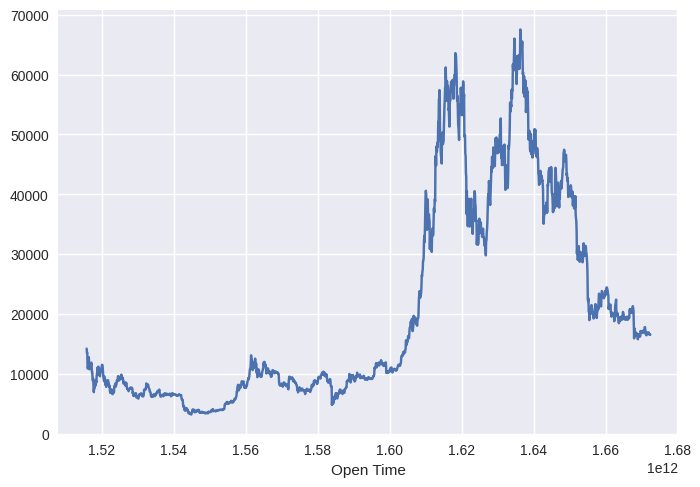

In [18]:
fm.df["Close"].plot()